To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Unsloth now supports Text-to-Speech (TTS) models. Read our [guide here](https://docs.unsloth.ai/basics/text-to-speech-tts-fine-tuning).

Read our **[Gemma 3N Guide](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [ ]:
from google.colab import userdata
userdata.get('HF_TOKEN')

In [7]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [8]:
!pip install spaces

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [5]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.model.vision_model.transformer` require gradients


<a name="Data"></a>
### Data Prep

In [10]:
import spaces
from datasets import load_dataset, Image

# Login using e.g. `huggingface-cli login` to access this dataset
indian_monuments_ds = load_dataset("AIMLOps-C4-G16/indian_monuments")

Resolving data files:   0%|          | 0/148 [00:00<?, ?it/s]

andhra_pradesh_000001.jpg:   0%|          | 0.00/287k [00:00<?, ?B/s]

andhra_pradesh_000003.jpg:   0%|          | 0.00/229k [00:00<?, ?B/s]

andhra_pradesh_000002.jpg:   0%|          | 0.00/220k [00:00<?, ?B/s]

andhra_pradesh_000004.png:   0%|          | 0.00/4.90M [00:00<?, ?B/s]

arunachal_pradesh_000001.jpg:   0%|          | 0.00/237k [00:00<?, ?B/s]

assam_000001.jpg:   0%|          | 0.00/166k [00:00<?, ?B/s]

andhra_pradesh_000005.jpg:   0%|          | 0.00/299k [00:00<?, ?B/s]

arunachal_pradesh_000002.jpg:   0%|          | 0.00/155k [00:00<?, ?B/s]

arunachal_pradesh_000004.jpg:   0%|          | 0.00/254k [00:00<?, ?B/s]

arunachal_pradesh_000005.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

arunachal_pradesh_000003.jpg:   0%|          | 0.00/75.4k [00:00<?, ?B/s]

assam_000002.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

assam_000004.jpg:   0%|          | 0.00/230k [00:00<?, ?B/s]

assam_000003.jpg:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

assam_000005.jpg:   0%|          | 0.00/754k [00:00<?, ?B/s]

bihar_000001.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

chandigarh_000002.jpg:   0%|          | 0.00/105k [00:00<?, ?B/s]

bihar_000004.jpg:   0%|          | 0.00/94.7k [00:00<?, ?B/s]

chandigarh_000004.jpg:   0%|          | 0.00/146k [00:00<?, ?B/s]

bihar_000002.jpg:   0%|          | 0.00/149k [00:00<?, ?B/s]

bihar_000005.jpg:   0%|          | 0.00/168k [00:00<?, ?B/s]

chandigarh_000005.jpg:   0%|          | 0.00/268k [00:00<?, ?B/s]

chandigarh_000003.jpg:   0%|          | 0.00/367k [00:00<?, ?B/s]

chhattisgarh_000004.jpg:   0%|          | 0.00/190k [00:00<?, ?B/s]

chhattisgarh_000001.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

chandigarh_000001.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

chhattisgarh_000002.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

chhattisgarh_000005.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

chhattisgarh_000003.jpg:   0%|          | 0.00/211k [00:00<?, ?B/s]

goa_000001.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

goa_000002.jpg:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

goa_000003.png:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

gujarat_000002.jpg:   0%|          | 0.00/154k [00:00<?, ?B/s]

goa_000004.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

gujarat_000001.jpg:   0%|          | 0.00/241k [00:00<?, ?B/s]

gujarat_000005.jpg:   0%|          | 0.00/433k [00:00<?, ?B/s]

gujarat_000003.jpg:   0%|          | 0.00/140k [00:00<?, ?B/s]

haryana_000001.jpg:   0%|          | 0.00/175k [00:00<?, ?B/s]

gujarat_000004.jpg:   0%|          | 0.00/177k [00:00<?, ?B/s]

himachal_pradesh_000004.jpg:   0%|          | 0.00/218k [00:00<?, ?B/s]

himachal_pradesh_000001.jpg:   0%|          | 0.00/606k [00:00<?, ?B/s]

haryana_000005.jpg:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

haryana_000002.jpg:   0%|          | 0.00/88.1k [00:00<?, ?B/s]

haryana_000003.jpg:   0%|          | 0.00/149k [00:00<?, ?B/s]

himachal_pradesh_000002.png:   0%|          | 0.00/489k [00:00<?, ?B/s]

jammu_and_kashmir_000002.jpg:   0%|          | 0.00/338k [00:00<?, ?B/s]

jammu_and_kashmir_000001.jpg:   0%|          | 0.00/307k [00:00<?, ?B/s]

himachal_pradesh_000005.jpg:   0%|          | 0.00/160k [00:00<?, ?B/s]

jammu_and_kashmir_000004.jpg:   0%|          | 0.00/175k [00:00<?, ?B/s]

jammu_and_kashmir_000005.jpg:   0%|          | 0.00/166k [00:00<?, ?B/s]

jharkhand_000002.jpg:   0%|          | 0.00/495k [00:00<?, ?B/s]

jharkhand_000004.jpg:   0%|          | 0.00/518k [00:00<?, ?B/s]

jharkhand_000003.jpg:   0%|          | 0.00/304k [00:00<?, ?B/s]

karnataka_000002.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

jharkhand_000005.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

karnataka_000001.jpg:   0%|          | 0.00/558k [00:00<?, ?B/s]

karnataka_000004.jpg:   0%|          | 0.00/513k [00:00<?, ?B/s]

karnataka_000003.jpg:   0%|          | 0.00/364k [00:00<?, ?B/s]

kerala_000001.jpg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

kerala_000004.jpg:   0%|          | 0.00/213k [00:00<?, ?B/s]

kerala_000003.jpg:   0%|          | 0.00/100k [00:00<?, ?B/s]

kerala_000002.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

ladakh_000001.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

kerala_000005.jpg:   0%|          | 0.00/242k [00:00<?, ?B/s]

madhya_pradesh_000001.jpg:   0%|          | 0.00/109k [00:00<?, ?B/s]

ladakh_000003.jpg:   0%|          | 0.00/5.30M [00:00<?, ?B/s]

ladakh_000004.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

ladakh_000002.jpg:   0%|          | 0.00/243k [00:00<?, ?B/s]

ladakh_000005.jpg:   0%|          | 0.00/576k [00:00<?, ?B/s]

madhya_pradesh_000004.jpg:   0%|          | 0.00/461k [00:00<?, ?B/s]

maharashtra_000004.jpg:   0%|          | 0.00/108k [00:00<?, ?B/s]

maharashtra_000005.jpg:   0%|          | 0.00/303k [00:00<?, ?B/s]

maharashtra_000002.jpg:   0%|          | 0.00/97.5k [00:00<?, ?B/s]

maharashtra_000003.jpg:   0%|          | 0.00/295k [00:00<?, ?B/s]

madhya_pradesh_000003.jpg:   0%|          | 0.00/168k [00:00<?, ?B/s]

manipur_000001.jpg:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

maharashtra_000001.jpg:   0%|          | 0.00/157k [00:00<?, ?B/s]

manipur_000003.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

manipur_000002.jpg:   0%|          | 0.00/282k [00:00<?, ?B/s]

manipur_000004.jpg:   0%|          | 0.00/139k [00:00<?, ?B/s]

manipur_000005.jpg:   0%|          | 0.00/116k [00:00<?, ?B/s]

meghalaya_000004.jpg:   0%|          | 0.00/208k [00:00<?, ?B/s]

meghalaya_000002.png:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

mizoram_000002.jpg:   0%|          | 0.00/162k [00:00<?, ?B/s]

meghalaya_000001.jpg:   0%|          | 0.00/125k [00:00<?, ?B/s]

meghalaya_000005.jpg:   0%|          | 0.00/340k [00:00<?, ?B/s]

meghalaya_000003.jpg:   0%|          | 0.00/650k [00:00<?, ?B/s]

mizoram_000001.jpg:   0%|          | 0.00/139k [00:00<?, ?B/s]

mizoram_000003.jpg:   0%|          | 0.00/159k [00:00<?, ?B/s]

mizoram_000004.jpg:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

nagaland_000001.jpg:   0%|          | 0.00/159k [00:00<?, ?B/s]

mizoram_000005.jpg:   0%|          | 0.00/5.27M [00:00<?, ?B/s]

nagaland_000003.jpg:   0%|          | 0.00/161k [00:00<?, ?B/s]

nagaland_000002.jpg:   0%|          | 0.00/131k [00:00<?, ?B/s]

nagaland_000004.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

nagaland_000005.jpg:   0%|          | 0.00/196k [00:00<?, ?B/s]

odisha_000001.jpg:   0%|          | 0.00/1.95M [00:01<?, ?B/s]

odisha_000002.jpg:   0%|          | 0.00/310k [00:01<?, ?B/s]

odisha_000003.jpg:   0%|          | 0.00/94.8k [00:01<?, ?B/s]

odisha_000004.jpg:   0%|          | 0.00/150k [00:01<?, ?B/s]

puducherry_000001.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

puducherry_000002.jpg:   0%|          | 0.00/138k [00:00<?, ?B/s]

punjab_000003.jpg:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

puducherry_000005.jpg:   0%|          | 0.00/245k [00:00<?, ?B/s]

punjab_000001.jpg:   0%|          | 0.00/254k [00:00<?, ?B/s]

puducherry_000004.jpg:   0%|          | 0.00/119k [00:00<?, ?B/s]

puducherry_000003.jpg:   0%|          | 0.00/146k [00:00<?, ?B/s]

rajasthan_000001.jpg:   0%|          | 0.00/803k [00:00<?, ?B/s]

punjab_000004.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

punjab_000005.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

rajasthan_000002.jpg:   0%|          | 0.00/214k [00:00<?, ?B/s]

rajasthan_000003.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

rajasthan_000004.jpg:   0%|          | 0.00/79.1k [00:00<?, ?B/s]

rajasthan_000005.jpg:   0%|          | 0.00/219k [00:00<?, ?B/s]

sikkim_000001.jpg:   0%|          | 0.00/192k [00:00<?, ?B/s]

sikkim_000004.jpg:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

sikkim_000003.jpg:   0%|          | 0.00/146k [00:00<?, ?B/s]

sikkim_000002.jpg:   0%|          | 0.00/7.54M [00:00<?, ?B/s]

sikkim_000005.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

tamil_nadu_000003.jpg:   0%|          | 0.00/209k [00:00<?, ?B/s]

tamil_nadu_000004.jpg:   0%|          | 0.00/2.70M [00:00<?, ?B/s]

tamil_nadu_000002.jpg:   0%|          | 0.00/211k [00:00<?, ?B/s]

tamil_nadu_000001.jpg:   0%|          | 0.00/156k [00:00<?, ?B/s]

tamil_nadu_000005.jpg:   0%|          | 0.00/176k [00:00<?, ?B/s]

telangana_000002.jpg:   0%|          | 0.00/271k [00:00<?, ?B/s]

telangana_000004.jpg:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

telangana_000001.jpg:   0%|          | 0.00/172k [00:00<?, ?B/s]

telangana_000003.jpg:   0%|          | 0.00/43.0k [00:00<?, ?B/s]

telangana_000005.png:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

tripura_000002.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

tripura_000001.jpg:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

tripura_000003.jpg:   0%|          | 0.00/175k [00:00<?, ?B/s]

tripura_000004.jpg:   0%|          | 0.00/807k [00:00<?, ?B/s]

tripura_000005.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

uttar_pradesh_000002.jpg:   0%|          | 0.00/780k [00:00<?, ?B/s]

uttar_pradesh_000001.jpg:   0%|          | 0.00/315k [00:00<?, ?B/s]

uttar_pradesh_000005.jpg:   0%|          | 0.00/251k [00:00<?, ?B/s]

uttarakhand_000001.jpg:   0%|          | 0.00/164k [00:00<?, ?B/s]

uttarakhand_000002.jpg:   0%|          | 0.00/82.6k [00:00<?, ?B/s]

uttarakhand_000003.jpg:   0%|          | 0.00/104k [00:00<?, ?B/s]

uttarakhand_000004.jpg:   0%|          | 0.00/93.1k [00:00<?, ?B/s]

uttarakhand_000005.jpg:   0%|          | 0.00/6.70M [00:00<?, ?B/s]

west_bengal_000001.jpg:   0%|          | 0.00/295k [00:00<?, ?B/s]

west_bengal_000002.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

west_bengal_000003.jpg:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

west_bengal_000004.png:   0%|          | 0.00/3.12M [00:00<?, ?B/s]

west_bengal_000005.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/148 [00:00<?, ? examples/s]

In [ ]:
#indian_festivals_ds = load_dataset("AIMLOps-C4-G16/IndianFestivals")

Let's take a look at the dataset, and check what the 1st example shows:

In [11]:
indian_monuments_ds

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 148
    })
})

In [12]:
len(indian_monuments_ds['train'])

148

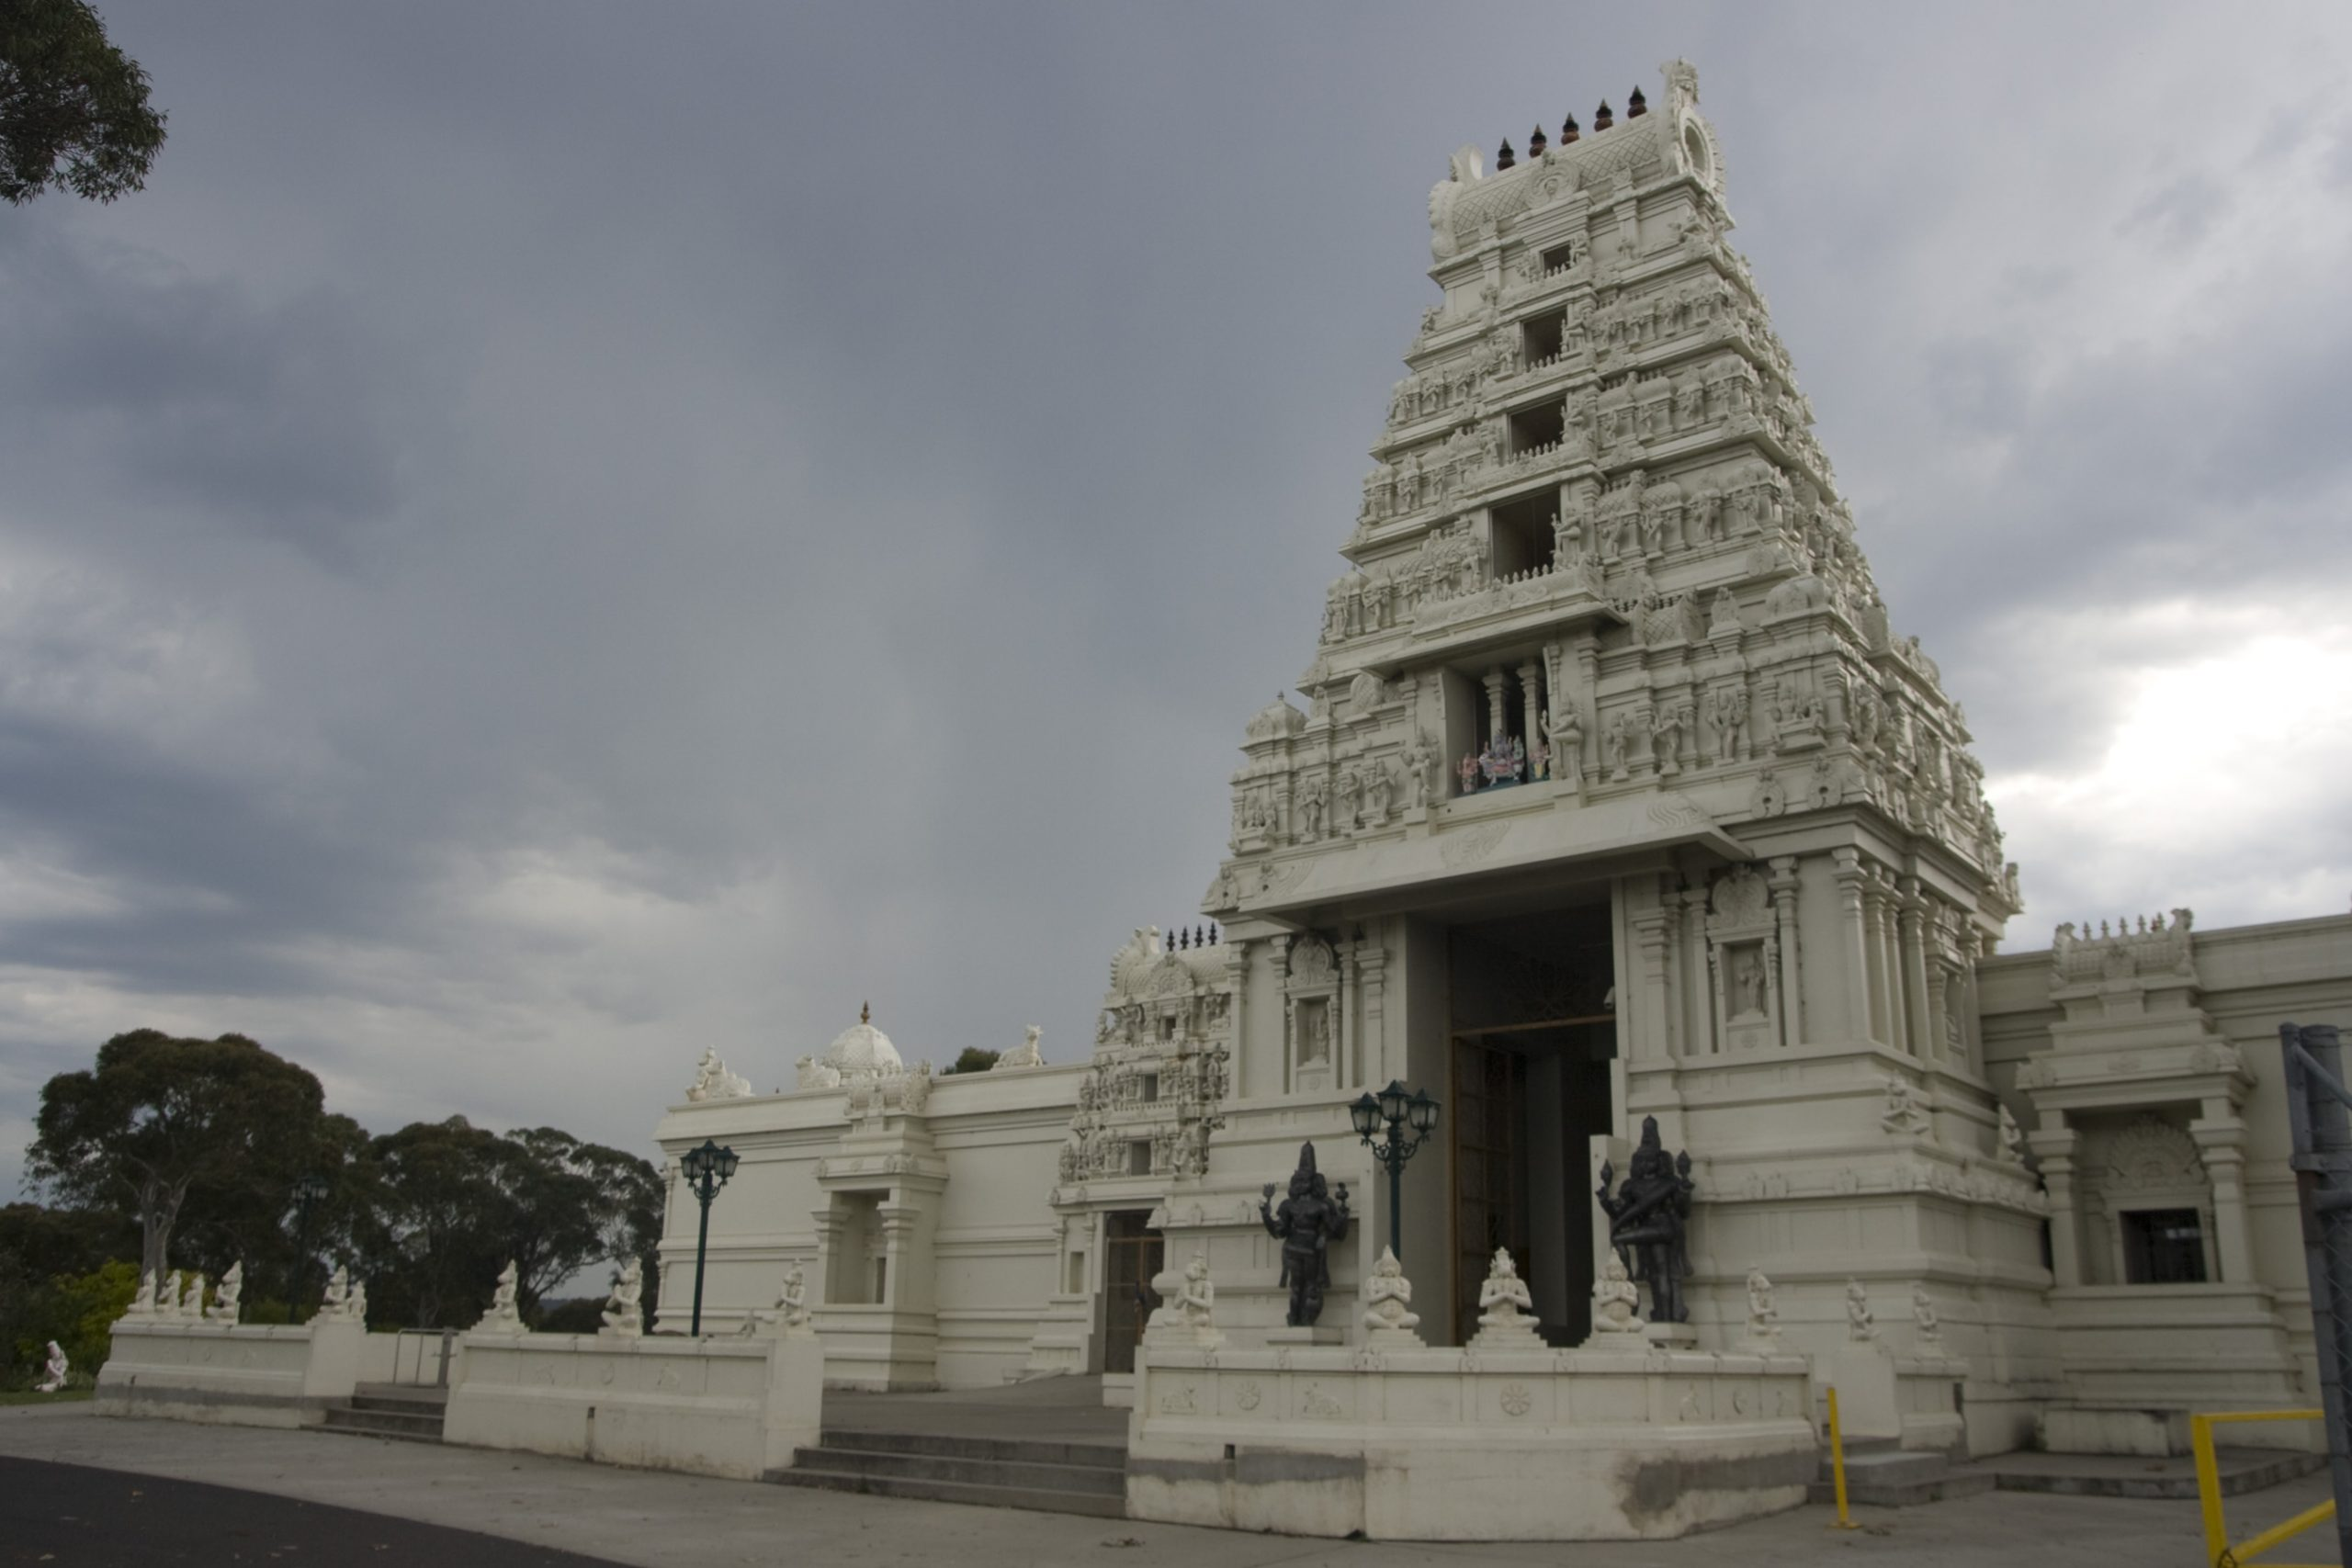

In [13]:
indian_monuments_ds['train'][0]["image"]

In [14]:
dataset = load_dataset("AIMLOps-C4-G16/indian_monuments", split="train").cast_column("image", Image(decode=False))
dataset[0]["image"]

Resolving data files:   0%|          | 0/148 [00:00<?, ?it/s]

{'bytes': None,
 'path': '/root/.cache/huggingface/hub/datasets--AIMLOps-C4-G16--indian_monuments/snapshots/eb757559335550d255472383fcfe1f4d493c5b97/andhra_pradesh_000001.jpg'}

In [15]:
list_of_image_names = []
for i in range(len(dataset)):
  list_of_image_names.append(((dataset[i]["image"])['path']).split('/')[-1])

In [16]:
list_of_image_names

['andhra_pradesh_000001.jpg',
 'andhra_pradesh_000002.jpg',
 'andhra_pradesh_000003.jpg',
 'andhra_pradesh_000004.png',
 'andhra_pradesh_000005.jpg',
 'arunachal_pradesh_000001.jpg',
 'arunachal_pradesh_000002.jpg',
 'arunachal_pradesh_000003.jpg',
 'arunachal_pradesh_000004.jpg',
 'arunachal_pradesh_000005.jpg',
 'assam_000001.jpg',
 'assam_000002.jpg',
 'assam_000003.jpg',
 'assam_000004.jpg',
 'assam_000005.jpg',
 'bihar_000001.jpg',
 'bihar_000002.jpg',
 'bihar_000004.jpg',
 'bihar_000005.jpg',
 'chandigarh_000001.jpg',
 'chandigarh_000002.jpg',
 'chandigarh_000003.jpg',
 'chandigarh_000004.jpg',
 'chandigarh_000005.jpg',
 'chhattisgarh_000001.jpg',
 'chhattisgarh_000002.jpg',
 'chhattisgarh_000003.jpg',
 'chhattisgarh_000004.jpg',
 'chhattisgarh_000005.jpg',
 'goa_000001.jpg',
 'goa_000002.jpg',
 'goa_000003.png',
 'goa_000004.jpg',
 'gujarat_000001.jpg',
 'gujarat_000002.jpg',
 'gujarat_000003.jpg',
 'gujarat_000004.jpg',
 'gujarat_000005.jpg',
 'haryana_000001.jpg',
 'haryana_00

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [13]:
FastVisionModel.for_inference(model) # Enable for inference!

image = indian_monuments_ds["train"][0]["image"]
instruction = "In a short sentence, briefly describe what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens=100,
                   use_cache = True, temperature=0.8, top_p=0.9, do_sample=True)

This image depicts the exterior of a Hindu temple, featuring white stone architecture and ornate details.<|eot_id|>


<a name="Inference"></a>
### Inference
Let's run the model!
We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

Generate 4 captions per image and write to a file

In [ ]:
'''
Captions file will be in this format:

img_name \t caption 0 \t caption 1 \t caption 2 \t caption 3 \n
'''

In [14]:
num_captions_per_image = 4

def generate_captions():
  with open('llama3.2_11b_vi_monuments_captions.txt', 'w') as f:
    for i in range(len(indian_monuments_ds['train'])):
      output = [""] * num_captions_per_image # Initialize with empty strings
      #temperature = 1.489
      for j in range(num_captions_per_image):
        image = indian_monuments_ds['train'][i]["image"]
        inputs = tokenizer(
                     image,
                     input_text,
                     add_special_tokens = False,
                     return_tensors = "pt",).to("cuda")
        text_streamer = TextStreamer(tokenizer, skip_prompt = True)
        #temperature += 0.001
        generated_output = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 100,
                                   use_cache = True, temperature=0.8, top_p=0.9, do_sample=True)
        # Decode the generated tensor into a string
        decoded_output = tokenizer.decode(generated_output[0], skip_special_tokens=True)
        # Extract the part after the prompt
        prompt_end_index = decoded_output.find(instruction) + len(instruction)
        caption = decoded_output[prompt_end_index:].strip()
        output[j] = caption
      f.write(list_of_image_names[i] + "\t" + output[0] + "\t" + output[1] + "\t" + output[2] + "\t" + output[3] + "\n")

In [ ]:
generate_captions()

In [ ]:
# Download llama3.2_11b_vi_monuments_captions.txt
from google.colab import files
files.download('llama3.2_11b_vi_monuments_captions.txt')

In [ ]:
'''
Feedback file will be in this format (-1 indicates reject)

img_name \t caption 0 \t caption 1 \t caption 2 \t caption 3 \t best_caption_number(-1,0,1,2,3) \n
'''

In [17]:
def get_next_image_and_captions(cnt):
  with open('llama3.2_11b_vi_monuments_captions.txt') as f:
    lines = f.readlines()
    if cnt < len(lines):
      img_name, c0, c1, c2, c3 = lines[cnt].strip().split('\t')
      image = indian_monuments_ds['train'][cnt]["image"]
      return image, c0, c1, c2, c3, cnt # Return image data
    else:
      return None, "", "", "", "", cnt # Return None for image when done

In [18]:
thanks_message = "Done"
def run_rlhf(c0, c1, c2, c3, best_caption_number, cnt):
  if c0 is not None:
    with open('rlhf_llama3.2_11b_monuments.txt', 'a') as f: # Use 'a' to append
      f.write(list_of_image_names[cnt] + "\t" + c0 + "\t" + c1 + "\t" + c2 + "\t" + c3 + "\t" + str(best_caption_number) + "\n")
  cnt += 1 # Increment the count
  if cnt < len(list_of_image_names):
    image, c0_new, c1_new, c2_new, c3_new, new_cnt = get_next_image_and_captions(cnt)
    return thanks_message, image, c0_new, c1_new, c2_new, c3_new, new_cnt
  else:
    return "Finished processing all images.", None, "", "", "", "", cnt # Indicate completion

In [19]:
def get_next_image(cnt):
  image = indian_monuments_ds['train'][cnt]["image"]
  return image

In [ ]:
get_next_image(cnt)

In [20]:
import gradio as gr

css = """
  #output {
    height: 500px;
    overflow: auto;
    border: 1px solid #ccc;
  }
"""
rlhf_btn = gr.Button("Submit")
output_img = gr.Image(label="Input Picture")
c0 = gr.Textbox(label="Caption 0")
c1 = gr.Textbox(label="Caption 1")
c2 = gr.Textbox(label="Caption 2")
c3 = gr.Textbox(label="Caption 3")

best_caption_number = gr.Textbox(label="Choose best caption number -1(None),0,1,2,3")
response_output = gr.Textbox(label="Response") # Add a textbox for the response
#count_state = gr.State(0) # State to hold the current count
#count_state = 0 # This line is incorrect, it should be a Gradio State

def load_initial_data(count_state_value):
    image, c0_val, c1_val, c2_val, c3_val, cnt = get_next_image_and_captions(count_state_value)
    return image, c0_val, c1_val, c2_val, c3_val, cnt

def run_rlhf(c0, c1, c2, c3, best_caption_number, count_state_value):
  if c0 is not None:
    with open('rlhf_llama3.2_11b_monuments.txt', 'a') as f: # Use 'a' to append
      f.write(list_of_image_names[count_state_value] + "\t" + c0 + "\t" + c1 + "\t" + c2 + "\t" + c3 + "\t" + str(best_caption_number) + "\n")
  cnt = count_state_value + 1 # Increment the count
  if cnt < len(list_of_image_names):
    image, c0_new, c1_new, c2_new, c3_new, new_cnt = get_next_image_and_captions(cnt)
    return thanks_message, image, c0_new, c1_new, c2_new, c3_new, new_cnt
  else:
    return "Finished processing all images.", None, "", "", "", "", cnt # Indicate completion


with gr.Blocks(css=css) as demo:
    gr.Markdown("RLHF")
    # Define count_state as a Gradio State
    count_state = gr.State(0)
    with gr.Tab(label="Real or Kidding?"):
        with gr.Row():
          with gr.Column():
            output_img.render()
          with gr.Column():
            c0.render()
            c1.render()
            c2.render()
            c3.render()
            best_caption_number.render()
            response_output.render()
            rlhf_btn.render()

            # Load initial data when the UI loads
            demo.load(load_initial_data, inputs=[count_state], outputs=[output_img, c0, c1, c2, c3, count_state])

            # Update data on button click
            rlhf_btn.click(
                run_rlhf,
                inputs=[c0, c1, c2, c3, best_caption_number, count_state],
                outputs=[response_output, output_img, c0, c1, c2, c3, count_state]
            )


demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://33bf9594bcba3cd7f7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ce8d46dca069eec5ac.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://33bf9594bcba3cd7f7.gradio.live


And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>
